# Chatbot Integrated with Tools and Memory

Creating a Simple Chatbot where it takes the user prompt as an Input and provides the completion as an output using Graph API.

**StateGraph:**

"START" -> Node[Prompt passed to LLM] -> "END"

Here, we have
- 2 Edges (START to Node, Node to END)

- 1 Node (Prompt passed to LLM)
- State contains `messages` variable which gets appended everytime with the LLM response generated.

## Importing Environment Variables

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Importing LangGraph Libraries

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

# LangGraph 
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # It is a Reducer, its main role is to append new messages to the variable which its defined.


## Initializing LLM 

In [3]:
from langchain_groq import ChatGroq # Type 1 Initialization 
from langchain.chat_models import init_chat_model # Type 2 Initialization - can be used with any chat model, not just Groq.

llm = ChatGroq(model="llama3-8b-8192")

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x107c66390>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x107621220>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Creating State 

In [4]:
class State(TypedDict):
    """
    Messages have the type "list". The `add_messages` function in the annotation
    defines how this state key should be updated. (In the current case, it appends messages to the list, rather than overwriting it.)
    """
    messages: Annotated[list, add_messages] # Annotated is used to add metadata to the type, in this case, it specifies that the `messages` list should be updated using the `add_messages` reducer. 

## Node Implementation for Chat Functionality

In [5]:
def chatBot(state: State): # Inheriting the State, since the state is passed to the function, it can be used to access and modify the state variables.
    return {"messages" : [llm.invoke(state["messages"])]}  # The function takes the current state, invokes the LLM with the messages, and returns the updated messages.

## Building Graph and adding Node and Edges

In [6]:
graph_builder = StateGraph(State)  # Create a StateGraph instance with the defined State type.

# Adding Node
graph_builder.add_node("llmchatbot", chatBot)  # Add the chatBot function as a node in the graph.

# Adding Edges
graph_builder.add_edge(START, "llmchatbot")  # Connect the START node to the llmchatbot node.
graph_builder.add_edge("llmchatbot", END)  # Connect the llmchatbot node to the END node.   

## Compiling the Graph

In [7]:
graph = graph_builder.compile()

## Visualizing the Graph

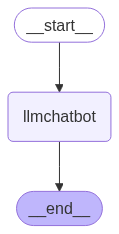

In [8]:
from IPython.display import Image, display

# Display the graph as an image
try: 
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Error displaying the graph:", e)

## Executing the Graph using `graph.invoke()`

In [9]:
response = graph.invoke(
    {
        "messages" : "Hello, I am Sai Kiran!"
    }
)

In [10]:
response

{'messages': [HumanMessage(content='Hello, I am Sai Kiran!', additional_kwargs={}, response_metadata={}, id='1d1aefda-8f9d-4ad2-a03c-35f80ca6ef89'),
  AIMessage(content="Nice to meet you, Sai Kiran! It's great to have you here. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 18, 'total_tokens': 43, 'completion_time': 0.070372557, 'prompt_time': 0.013659638, 'queue_time': 0.35284841100000003, 'total_time': 0.084032195}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--7afac6a0-bf0d-4ab9-b0d2-3a73237884cf-0', usage_metadata={'input_tokens': 18, 'output_tokens': 25, 'total_tokens': 43})]}

In the above output, we have received, if we remember correctly when creating the "State", we have mentioned `messages` as the list annotated with `add_messages` reducer. 

Here, the role of 
- `Annotated` is to convert the provided messages to either the Human or AI Message 

- `add_messages` reducer is making sure that the messages are getting appended to each other in a response. First the user input, next the LLM response. 

In [11]:
response["messages"][-1].content

"Nice to meet you, Sai Kiran! It's great to have you here. How can I assist you today?"

## Executing the Graph using `graph.stream()`

In [12]:
for event in graph.stream({ "messages" : "Hi, how are you doing?"}): 

    for value in event.values():
        print(value["messages"][-1].content)

I'm just a language model, I don't have emotions or feelings like humans do, so I don't have a personal state of being. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?


---

## Integrating Tavily Search 

Tavily Search is just like Serper Tool in CrewAI, which does the google searches and provide the LLM with the recent or latest updates. 

In [13]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(max_results=2) # limiting the searches to 2 results for brevity

tavily_search_tool.invoke("What is the recent AI news today?")

{'query': 'What is the recent AI news today?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'AI News | Latest AI News, Analysis & Events',
   'url': 'https://www.artificialintelligence-news.com/',
   'content': 'AI News reports on the latest artificial intelligence news and insights. Explore industry trends from the frontline of AI.',
   'score': 0.63234437,
   'raw_content': None},
  {'title': 'AI News & Artificial Intelligence | TechCrunch',
   'url': 'https://techcrunch.com/category/artificial-intelligence/',
   'content': 'News coverage on artificial intelligence and machine learning tech, the companies building them, and the ethical issues AI raises today. This encompasses generative AI, including large language',
   'score': 0.58237284,
   'raw_content': None}],
 'response_time': 10.51}

## Creating Custom Tool/Function - `multiply()`

In [14]:
def multiply(a:int, b:int) -> int: 
    '''
    Multiply a and b 

    Args:
        a (int): first int
        b (int): second int 

    Returns: 
        int: output    
    
    '''
    return a * b 

## Adding Tools and Binding with LLM

**Binding** the LLM with tools, makes the LLM knows what tools are present for it to access. Each tool should have the docstrings attached if not necessary, as it helps the LLM know which tool need to be chosen during the query execution.

In [15]:
tools = [tavily_search_tool, multiply] # adding tools in the list 

llm_with_tools = llm.bind_tools(tools) # Binding the LLM with tools

In [16]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x107c66390>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x107621220>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to 

## Adding `tool_calling_llm` Node definition

In [17]:
def tool_calling_llm(state: State):

    return { "messages": [llm_with_tools.invoke(state["messages"])]} # We are using the LLM which was binded with tools.

## Creating StateGraph

In [18]:
# Importing required libraries
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State) # using the same State class again which we have created earlier having messages attribute

# Adding Nodes
builder.add_node("tool_calling_llm", tool_calling_llm) # Adding the definition of the node
builder.add_node("tools", ToolNode(tools)) # Irrespective of number of tools, we can use the ToolNode function to add it as a single Node in the graph. 

# Adding Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # If the latest message (result) from the assistant (LLM) node is a tool call -> tools_condition routes to tools node.
    # Tf the latest messsage (result) from the assistant (LLM) node is not a tool call -> tools_condition routes to END node.
    tools_condition
)
builder.add_edge("tools", END) # Adding the edge from tools node to END node.


Compiling the graph with all the edges and nodes defined

In [19]:
chatbot_with_tools_graph = builder.compile() # Compiling the graph

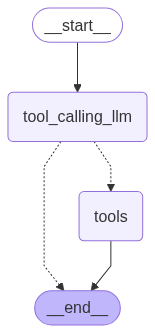

In [20]:
chatbot_with_tools_graph

## Testing the graph with queries

### Case 1: Making LLM to call the Tavily Search tool 

In [21]:
response = chatbot_with_tools_graph.invoke(
    {
        "messages" : "What are the recent news in AI?"
    }
)

# Printing the response from the LLM after invoking the graph with a message.
response

{'messages': [HumanMessage(content='What are the recent news in AI?', additional_kwargs={}, response_metadata={}, id='491ba835-249c-44e7-b005-d2f6c3ee1fdf'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5qznv9jkp', 'function': {'arguments': '{"query":"Recent news in AI","search_depth":"advanced","time_range":"week","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 2196, 'total_tokens': 2290, 'completion_time': 0.203468466, 'prompt_time': 0.267609567, 'queue_time': 0.36934047100000006, 'total_time': 0.471078033}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--41fd5304-2dc2-40a9-8b6f-b8a3e5f54ea5-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Recent news in AI', 'search_depth': 'advanced', 'time_range': 'week', 'topic': 'news'}, 'id': '5qznv9jkp', 'type': 'tool_call'}], usage_met

In [22]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What are the recent news in AI?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (5qznv9jkp)
 Call ID: 5qznv9jkp
  Args:
    query: Recent news in AI
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "Recent news in AI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/2025/06/24/new-data-highlights-the-race-to-build-more-empathetic-language-models/", "title": "New data highlights the race to build more empathetic language models - TechCrunch", "score": 0.6429039, "published_date": "Tue, 24 Jun 2025 21:03:01 GMT", "content": "Image 3: grapic depiction of white soundwaves on pinkish background\n\nImage Credits:Bryce Durbin/TechCrunch\n\nAI\n\n[](\n\nNew data highlights t

### Case 2: Making LLM to call the Multiply Function tool

In [23]:
response = chatbot_with_tools_graph.invoke(
    {
        "messages" : "What is 54 multiplied by 23 and then multipled by 10?"
    }
)

# Printing the response from the LLM after invoking the graph with a message.
response

{'messages': [HumanMessage(content='What is 54 multiplied by 23 and then multipled by 10?', additional_kwargs={}, response_metadata={}, id='17c861d4-cba3-4cea-924d-ada32b08f347'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8v4xd3t39', 'function': {'arguments': '{"a":54,"b":23}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'syng0dj2k', 'function': {'arguments': '{"a":123,"b":10}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 125, 'prompt_tokens': 2204, 'total_tokens': 2329, 'completion_time': 0.155250159, 'prompt_time': 0.245153648, 'queue_time': 0.27071582200000005, 'total_time': 0.400403807}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8af39bf2ae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--848344cb-b08b-44fc-b78e-c55cc59ba5ed-0', tool_calls=[{'name': 'multiply', 'args': {'a': 54, 'b': 23}, 'id': '8v4xd3t39', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 123, 'b'

In [24]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 54 multiplied by 23 and then multipled by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (8v4xd3t39)
 Call ID: 8v4xd3t39
  Args:
    a: 54
    b: 23
  multiply (syng0dj2k)
 Call ID: syng0dj2k
  Args:
    a: 123
    b: 10
================================= Tool Message =================================
Name: multiply

1242
================================= Tool Message =================================
Name: multiply

1230


### Case 3: Making LLM to call two tools at the same time - Tavily and Multiply tool

In [29]:
response = chatbot_with_tools_graph.invoke(
    {
        "messages" : "Tell me the recent news in AI and then multiply 10 and 2"
    }
)

# Printing the response from the LLM after invoking the graph with a message.
response

{'messages': [HumanMessage(content='Tell me the recent news in AI and then multiply 10 and 2', additional_kwargs={}, response_metadata={}, id='b7b7973a-a7ba-4635-9256-563a10b5e3c9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gq76bf0vw', 'function': {'arguments': '{"query":"recent news in AI","search_depth":"advanced","time_range":"week","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': '9cwcx11y4', 'function': {'arguments': '{"a":10,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 241, 'prompt_tokens': 2203, 'total_tokens': 2444, 'completion_time': 0.434327969, 'prompt_time': 0.300303078, 'queue_time': 0.35716562500000004, 'total_time': 0.734631047}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--92d0c4f8-f378-4240-b8c4-b1bd794e40b3-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'rece

In [30]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Tell me the recent news in AI and then multiply 10 and 2
================================== Ai Message ==================================
Tool Calls:
  tavily_search (gq76bf0vw)
 Call ID: gq76bf0vw
  Args:
    query: recent news in AI
    search_depth: advanced
    time_range: week
    topic: general
  multiply (9cwcx11y4)
 Call ID: 9cwcx11y4
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: tavily_search

{"query": "recent news in AI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "title": "Latest AI Breakthroughs and News: May-June 2025 - Crescendo.ai", "content": "Summary: OpenAI launched \"Operator,\" a new AI assistant capable of handling various online tasks, such as ordering groceries and processing ticket purchases.", "score": 0.77589405, "raw

---

## Leveraging ReAct Agent (Backbone of Agentic AI Framework) 

In the above cases, our state graph is working fine and doing the required tool calls, until and unless there are two tools and the tasks are mentioned one after another. 

But it fails when we give three action items all at once. Like (Get recent news in AI) -> (Multiply 5 * 10) -> (Get latest news in India). 

To solve this we will use the ReAct framework which contains three main components: 
1. Act - does the tool calling and performs one task

2. Observe - checks if there are any pending tasks
3. Reason - LLM takes the decision whether if it needs to another tool call or not. 

Now, let's change our StateGraph flow making the `tools_node` connect back to the `tool_calling_llm` instead to the `END`. Then once first tool call is executed, as LLM preserves the user context, it understands it needs to do another tool call or not, and finally it goes to END. 

In [31]:
# Importing required libraries - NO CHANGE REQUIRED
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State) # using the same State class again which we have created earlier having messages attribute

# Adding Nodes - NO CHANGE REQUIRED
builder.add_node("tool_calling_llm", tool_calling_llm) # Adding the definition of the node
builder.add_node("tools", ToolNode(tools)) # Irrespective of number of tools, we can use the ToolNode function to add it as a single Node in the graph. 

# Adding Edges 
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # If the latest message (result) from the assistant (LLM) node is a tool call -> tools_condition routes to tools node.
    # Tf the latest messsage (result) from the assistant (LLM) node is not a tool call -> tools_condition routes to END node.
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm") # Adding the edge from tools node to END node.


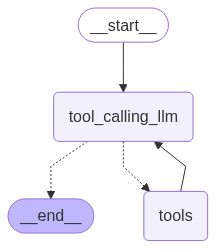

In [33]:
react_graph = builder.compile() # Compiling the graph

react_graph

## Testing the updated graph 

In [36]:
response = react_graph.invoke(
    {
        "messages" : "First tell the recent news in AI, second multiply 10 and 2 and then finally tell me today's news happened in India."
    }
)

# Printing the response from the LLM after invoking the graph with a message.
response

{'messages': [HumanMessage(content="First tell the recent news in AI, second multiply 10 and 2 and then finally tell me today's news happened in India.", additional_kwargs={}, response_metadata={}, id='ed8a8fdc-6c32-4b16-8108-86dffc7abfa9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'q8w34ks94', 'function': {'arguments': '{"query":"recent news in AI","search_depth":"advanced","time_range":"day"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'sxvyqktcd', 'function': {'arguments': '{"a":10,"b":2}', 'name': 'multiply'}, 'type': 'function'}, {'id': '1h1h8zjh9', 'function': {'arguments': '{"query":"today\'s news in India","search_depth":"advanced","time_range":"day"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 209, 'prompt_tokens': 2215, 'total_tokens': 2424, 'completion_time': 0.267413814, 'prompt_time': 0.245614983, 'queue_time': 0.271234987, 'total_time': 0.513028797}, 'model_name': 'llama3-8b

In [38]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

First tell the recent news in AI, second multiply 10 and 2 and then finally tell me today's news happened in India.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (q8w34ks94)
 Call ID: q8w34ks94
  Args:
    query: recent news in AI
    search_depth: advanced
    time_range: day
  multiply (sxvyqktcd)
 Call ID: sxvyqktcd
  Args:
    a: 10
    b: 2
  tavily_search (1h1h8zjh9)
 Call ID: 1h1h8zjh9
  Args:
    query: today's news in India
    search_depth: advanced
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "recent news in AI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cnbc.com/2025/06/26/ai-reasoning-models-problem.html", "title": "AI's reasoning problems -- why 'thinking' models may not be smarter", "content": 

---

## Adding Memory 

Till now, the number of conversations that we do with the Graph are not persistent. 

For example: 

- **Turn 1:** Inform LLM your name, and it provides helpful response like "Nice to meet you! ..."

- **Turn 2:** Ask LLM about your name, it says "I don't know your name ..."

It is happening because, the conversation is not getting stored anywhere. LangGraph has a special library named `MemorySaver` which helps us to persist the memory. 

Let us use the same StateGraph definition above, and tweak it little bit and add our memory. 

In [54]:
# Importing required libraries - IMPORTED MEMORYSAVER LIBRARY
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(State) # using the same State class again which we have created earlier having messages attribute

memory = MemorySaver() # This stores the state of the graph in memory, so that it can be used later to resume the graph execution or to retrieve the state. In short, it stores the "interactions" with the graph in memory.

# Adding Nodes - NO CHANGE REQUIRED
builder.add_node("tool_calling_llm", tool_calling_llm) # Adding the definition of the node
builder.add_node("tools", ToolNode(tools)) # Irrespective of number of tools, we can use the ToolNode function to add it as a single Node in the graph. 

# Adding Edges 
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm", 
    # If the latest message (result) from the assistant (LLM) node is a tool call -> tools_condition routes to tools node.
    # Tf the latest messsage (result) from the assistant (LLM) node is not a tool call -> tools_condition routes to END node.
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm") # Adding the edge from tools node to END node.

# Note: Remember to pass the memory object in checkpointer argument during the graph compilation step.
react_graph_with_memory = builder.compile(checkpointer=memory) 

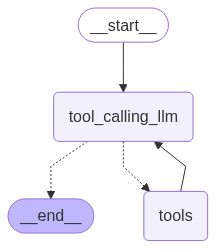

In [55]:
react_graph_with_memory

### Creating a configurable `thread` parameter 

This plays a crucial role in memory. The thread ID will be unique to each user session in real-time. Once the user initiates the session, the thread ID will be created and the memory will be limited to this particular thread. 

Once a new thread is created, memory gets created from scratch. 

In [56]:
config = {"configurable" : {"thread_id": "user_1"}}

### Invoking the graph with the prompt 

In [58]:
# Passing the config object to the invoke method, which will be used to store the state in memory with the key "user_1".
response = react_graph_with_memory.invoke({"messages" : "Hey, my Name is Sai Kiran!"}, config=config) 

response["messages"][-1].content

'Nice to meet you, Sai Kiran!'

### Asking about the details passed in the previous prompt

In [59]:
response = react_graph_with_memory.invoke({"messages" : "Do you know my name?"}, config=config) 

response["messages"][-1].content

'Yes, your name is Sai Kiran'